🎯 오늘의 미션 (Day 13)
AI에게 와이파이의 정보(설치 유형, 좌표, 연도 등)만 주고, **"이 와이파이는 실내에 있을까, 실외에 있을까?"**를 맞추게 시킨 뒤, SHAP으로 그 이유를 따져보는 겁니다.

예측 목표: 실내외구분 (실내 vs 실외)

사용 데이터: 설치유형, 망종류, 설치년도, GPS 좌표(X, Y)

In [4]:
import pandas as pd
import numpy as np
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import accuracy_score

plt.rc('font', family='D2Coding')
plt.rcParams['axes.unicode_minus'] = False

file_path = r"C:\Users\sangh\OneDrive\바탕 화면\AI\Ecommerce-Data-Analysis-Practice\data\서울시 관악구 공공와이파이 서비스 위치 정보.csv"

df = pd.read_csv(file_path, encoding='cp949')

features = ['설치유형', '망종류', '설치년도', 'X좌표', 'Y좌표']
target = '실내외구분'

df = df.dropna(subset=features + [target])

le_dict = {}
for col in ['설치유형', '망종류']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

le_target = LabelEncoder()
y = le_target.fit_transform(df[target])
X = df[features]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),  # 나무의 개수 (100~500개)
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),  # 학습 속도
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # 나무의 깊이
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # 데이터 샘플링 비율
        'colsample_bytree': trial.suggest_float('colsamply_bytree', 0.5, 1.0),  # 컬럼 샘플링 비율
        'random_state': 42
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_val)
    accuracy = accuracy_score(y_val, preds)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("-" * 30)
print(f"🏆 최고의 정확도: {study.best_value:.4f}")
print("🏆 최적의 파라미터:", study.best_params)

best_model = XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)


[I 2025-12-23 17:08:03,458] A new study created in memory with name: no-name-980e3761-4732-435a-a76a-d0e4e36d5a62


[I 2025-12-23 17:08:03,590] Trial 0 finished with value: 0.9933333333333333 and parameters: {'n_estimators': 208, 'learning_rate': 0.2517205801126316, 'max_depth': 4, 'subsample': 0.6018317991155646, 'colsamply_bytree': 0.8835656877479864}. Best is trial 0 with value: 0.9933333333333333.
[I 2025-12-23 17:08:03,731] Trial 1 finished with value: 0.9933333333333333 and parameters: {'n_estimators': 216, 'learning_rate': 0.18589869118558083, 'max_depth': 4, 'subsample': 0.6713702845061136, 'colsamply_bytree': 0.6866225329299325}. Best is trial 0 with value: 0.9933333333333333.
[I 2025-12-23 17:08:03,988] Trial 2 finished with value: 0.9933333333333333 and parameters: {'n_estimators': 449, 'learning_rate': 0.1543851809937626, 'max_depth': 9, 'subsample': 0.7521651639740847, 'colsamply_bytree': 0.7267345074352405}. Best is trial 0 with value: 0.9933333333333333.
[I 2025-12-23 17:08:04,231] Trial 3 finished with value: 0.9933333333333333 and parameters: {'n_estimators': 487, 'learning_rate': 0

------------------------------
🏆 최고의 정확도: 0.9933
🏆 최적의 파라미터: {'n_estimators': 208, 'learning_rate': 0.2517205801126316, 'max_depth': 4, 'subsample': 0.6018317991155646, 'colsamply_bytree': 0.8835656877479864}


C:\Users\sangh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [17:08:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "colsamply_bytree" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, colsamply_bytree=0.8835656877479864,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2517205801126316,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=208, n_jobs=None, ...)

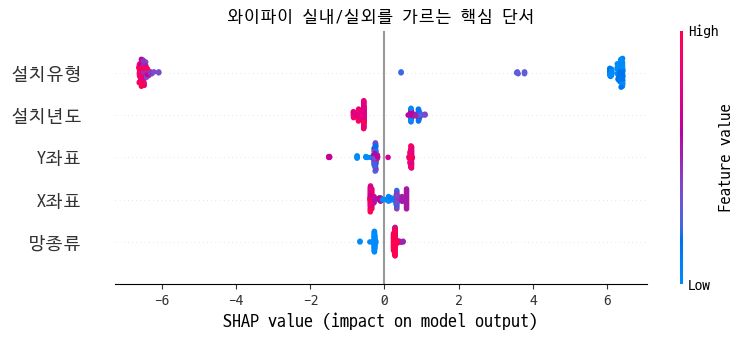

실제 정답: 실외
AI 예측: 실외


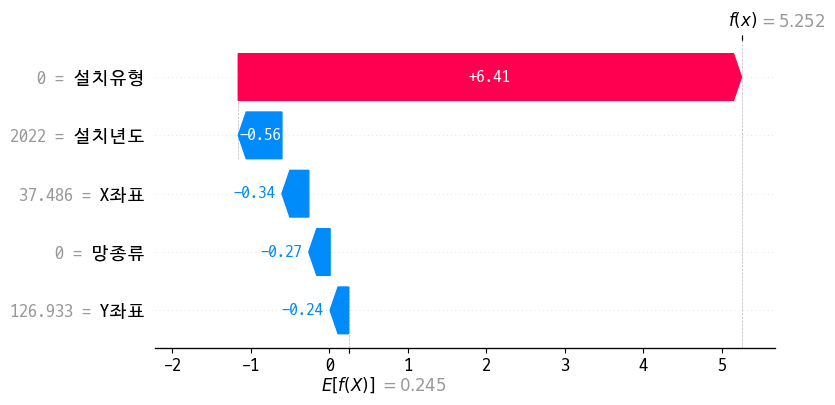

In [5]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_val)

plt.figure()
plt.title("와이파이 실내/실외를 가르는 핵심 단서")
shap.summary_plot(shap_values, X_val)

sample_idx=0
print(f"실제 정답: {le_target.inverse_transform([y_val[sample_idx]])[0]}")
print(f"AI 예측: {le_target.inverse_transform([best_model.predict(X_val.iloc[[sample_idx]])[0]])[0]}")

shap.plots.waterfall(shap_values[sample_idx])

[I 2025-12-23 17:38:29,770] A new study created in memory with name: no-name-00096af7-ebec-41b4-9f97-81b1fd038859
[I 2025-12-23 17:38:30,130] Trial 0 finished with value: 0.9533333333333334 and parameters: {'n_estimators': 393, 'learning_rate': 0.2445578179076544, 'max_depth': 10, 'subsample': 0.6631826745598322, 'colsample_bytree': 0.6196434252130585}. Best is trial 0 with value: 0.9533333333333334.
[I 2025-12-23 17:38:30,487] Trial 1 finished with value: 0.9466666666666667 and parameters: {'n_estimators': 355, 'learning_rate': 0.24615989619189627, 'max_depth': 9, 'subsample': 0.6007775691152129, 'colsample_bytree': 0.6934239579922646}. Best is trial 0 with value: 0.9533333333333334.
[I 2025-12-23 17:38:30,899] Trial 2 finished with value: 0.9533333333333334 and parameters: {'n_estimators': 404, 'learning_rate': 0.2834653716010637, 'max_depth': 7, 'subsample': 0.657278493047663, 'colsample_bytree': 0.6648674256171836}. Best is trial 0 with value: 0.9533333333333334.
[I 2025-12-23 17:3

------------------------------
🏆 최고의 정확도: 0.9733
🏆 최적의 파라미터: {'n_estimators': 205, 'learning_rate': 0.06934583983869955, 'max_depth': 6, 'subsample': 0.9963293318853177, 'colsample_bytree': 0.8440581210235174}
📉 '설치유형' 뺀 후 정확도: 0.9733


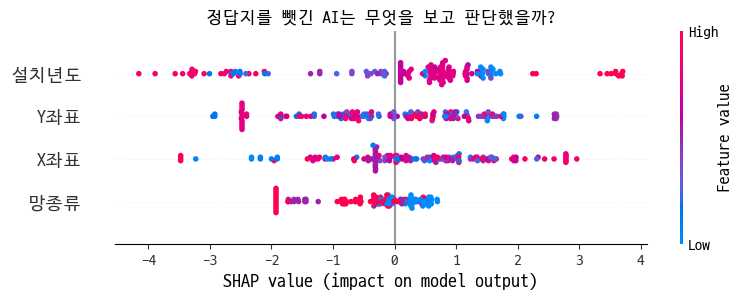

In [12]:
# 1. '설치유형'을 과감하게 삭제! (진검승부)
# 오직 좌표(X, Y)와 망종류, 설치년도만 줍니다.
features = ['망종류', '설치년도', 'X좌표', 'Y좌표'] 
target = '실내외구분'

le_target = LabelEncoder()
y = le_target.fit_transform(df[target])
X = df[features]

# 2. 다시 학습 및 평가 (데이터는 아까 로드한 df 그대로 사용)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),  # 나무의 개수 (100~500개)
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),  # 학습 속도
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # 나무의 깊이
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # 데이터 샘플링 비율
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # 컬럼 샘플링 비율
        'random_state': 42
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_val)
    accuracy = accuracy_score(y_val, preds)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("-" * 30)
print(f"🏆 최고의 정확도: {study.best_value:.4f}")
print("🏆 최적의 파라미터:", study.best_params)

best_model = XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)

# 정확도 확인
from sklearn.metrics import accuracy_score
print(f"📉 '설치유형' 뺀 후 정확도: {accuracy_score(y_val, best_model.predict(X_val)):.4f}")

# 3. SHAP으로 다시 분석 (이제 진짜 이유가 나옵니다)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_val)

plt.title("정답지를 뺏긴 AI는 무엇을 보고 판단했을까?")
shap.summary_plot(shap_values, X_val)